In [593]:
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [594]:
dataset = 'data/datasets_779_1465_atp_matches_2000.csv'
# Format datetime
dateparse = lambda x: pd.datetime.strptime(x, '%Y%m%d')
df = pd.read_csv(dataset, parse_dates=['tourney_date'], date_parser=dateparse)
# Remove rows with missing target, separate target from predictors
df.dropna(axis=0, subset=['winner_name'], inplace=True)
df.columns
# maybe divide columns between losers and winners.

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'winner_rank', 'winner_rank_points', 'loser_id', 'loser_seed',
       'loser_entry', 'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc',
       'loser_age', 'loser_rank', 'loser_rank_points', 'score', 'best_of',
       'round', 'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon',
       'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df',
       'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved',
       'l_bpFaced'],
      dtype='object')

In [595]:
df = df.drop(columns=['score','tourney_id','winner_id','loser_id','match_num','winner_hand','loser_hand'])

In [596]:
df.nunique(axis=0)

tourney_name           153
surface                  4
draw_size                8
tourney_level            5
tourney_date            52
winner_seed             25
winner_entry             3
winner_name            332
winner_ht               15
winner_ioc              74
winner_age            1534
winner_rank            336
winner_rank_points    1076
loser_seed              32
loser_entry              3
loser_name             460
loser_ht                14
loser_ioc               78
loser_age             2404
loser_rank             442
loser_rank_points     1321
best_of                  2
round                    9
minutes                202
w_ace                   37
w_df                    19
w_svpt                 174
w_1stIn                119
w_1stWon                90
w_2ndWon                50
w_SvGms                 31
w_bpSaved               22
w_bpFaced               28
l_ace                   32
l_df                    20
l_svpt                 173
l_1stIn                115
l

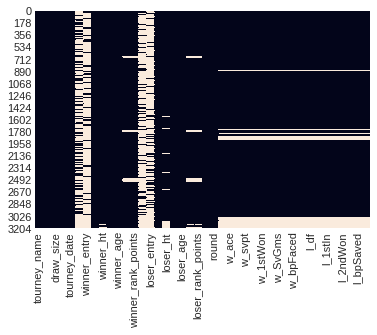

In [597]:
sns.heatmap(df.isnull(), cbar=False)



In [626]:
limitPer = len(df) * .80
df = df.dropna(thresh=limitPer,axis=1)

X = df.drop(['winner_name'], axis=1)
y = df.w_ace

X.head()

df.head()

,tourney_name,surface,draw_size,tourney_level,tourney_date,winner_name,winner_ht,winner_ioc,winner_age,winner_rank,...,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced
0,Orlando,Clay,32,A,2000-05-01,Antony Dupuis,185.0,FRA,27.181383,113.0,...,15.0,13.0,4.0,110.0,59.0,49.0,31.0,17.0,4.0,4.0
1,Orlando,Clay,32,A,2000-05-01,Fernando Gonzalez,183.0,CHI,19.756331,352.0,...,6.0,0.0,0.0,57.0,24.0,13.0,17.0,10.0,4.0,9.0
2,Orlando,Clay,32,A,2000-05-01,Paradorn Srichaphan,185.0,THA,20.881588,103.0,...,0.0,2.0,2.0,65.0,39.0,22.0,10.0,8.0,6.0,10.0
3,Orlando,Clay,32,A,2000-05-01,Jan Siemerink,183.0,NED,30.047912,107.0,...,12.0,4.0,6.0,104.0,57.0,35.0,24.0,15.0,6.0,11.0
4,Orlando,Clay,32,A,2000-05-01,Jason Stoltenberg,185.0,AUS,30.075291,74.0,...,1.0,0.0,3.0,47.0,28.0,17.0,10.0,8.0,3.0,6.0


In [599]:
df_winners = [col for col in df.columns if 'winner_' in col[:7] or 'w_' in col[0:2]]
df_loser = [col for col in df.columns if 'loser_' in col[:7] or 'l_' in col[0:2]]

df_l = df[df_loser]
df_w = df[df_winners]
df_l.describe()


,loser_ht,loser_age,loser_rank,loser_rank_points,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced
count,3174.000000,3364.000000,3158.000000,3158.000000,2941.000000,2941.000000,2941.000000,2941.000000,2941.000000,2941.000000,2941.000000,2941.000000,2941.000000
mean,184.159105,25.227831,119.264091,735.150728,5.051343,3.903094,80.158109,45.558654,30.458348,15.782387,12.180211,4.975519,8.982319
std,6.334978,3.490324,180.658968,641.910935,4.562910,2.797191,28.419713,18.166456,13.588112,7.447794,4.108829,3.381635,4.239877
min,168.000000,15.227926,1.000000,1.000000,0.000000,0.000000,5.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,180.000000,22.679671,35.000000,329.000000,2.000000,2.000000,60.000000,33.000000,21.000000,10.000000,9.000000,2.000000,6.000000
50%,185.000000,25.134839,68.000000,597.000000,4.000000,3.000000,75.000000,43.000000,28.000000,15.000000,11.000000,4.000000,8.000000
75%,188.000000,27.646817,120.000000,930.000000,7.000000,5.000000,95.000000,55.000000,38.000000,20.000000,15.000000,7.000000,11.000000
max,201.000000,38.784394,1351.000000,5085.000000,37.000000,21.000000,248.000000,147.000000,120.000000,60.000000,40.000000,25.000000,32.000000


In [560]:
df_w.describe()

,winner_ht,winner_age,winner_rank,winner_rank_points,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced
count,3262.000000,3363.000000,3200.000000,3200.000000,2941.000000,2941.000000,2941.000000,2941.000000,2941.000000,2941.000000,2941.000000,2941.000000,2941.000000
mean,184.803188,25.062957,86.060312,1011.944062,6.534172,3.080585,77.878273,45.264196,34.189391,17.912275,12.345801,3.708603,5.398504
std,6.324789,3.423037,150.659404,833.106568,5.050150,2.611064,28.926663,18.135410,12.900977,7.375990,4.077703,3.219375,4.195517
min,168.000000,15.734428,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,180.000000,22.583162,19.000000,473.000000,3.000000,1.000000,56.000000,32.000000,25.000000,13.000000,9.000000,1.000000,2.000000
50%,185.000000,24.903491,46.000000,795.000000,5.000000,3.000000,73.000000,42.000000,32.000000,17.000000,11.000000,3.000000,5.000000
75%,190.000000,27.462012,87.000000,1243.000000,9.000000,4.000000,94.000000,55.000000,41.000000,22.000000,15.000000,5.000000,8.000000
max,208.000000,38.611910,1312.000000,5208.000000,39.000000,18.000000,224.000000,145.000000,113.000000,61.000000,41.000000,22.000000,28.000000


In [ ]:
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=1, wspace=1):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object and dataset.dtypes[column] != np.dtype('<M8[ns]'):
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        elif dataset.dtypes[column] != np.dtype('<M8[ns]'):
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)
    
plot_distribution(df.dropna(), cols=3, width=20, height=50, hspace=0.45, wspace=0.45)


In [692]:
df['draw_size'].astype('object')
numeric_data = df.select_dtypes(exclude=['object', 'datetime64'])
categorical_data = df.select_dtypes(include='object')


In [562]:
#X.tourney_name.unique()

tourn_by_surface =  df.groupby('surface', as_index = True)['tourney_name'].nunique()
matchcount_by_surface = df.groupby('surface', as_index = True)['tourney_name'].count()
#tourn_by_surface.plot(kind="bar", stacked=True)
frame = { 'Tournaments': tourn_by_surface, 'Matches': matchcount_by_surface } 
  
result = pd.DataFrame(frame) 
result.head()

,Tournaments,Matches
surface,,
Carpet,21,208
Clay,57,1119
Grass,11,326
Hard,64,1711


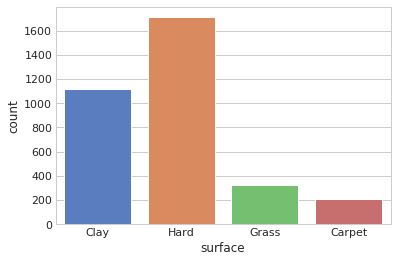

In [563]:
sns.set_style('whitegrid')
sns.countplot(x='surface',data=X)


In [627]:
# from sklearn.preprocessing import LabelEncoder
# creating instance of labelencoder
# labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
# X['surface'] = labelencoder.fit_transform(X['surface'])

# distrubition of frequency on dependent feature 


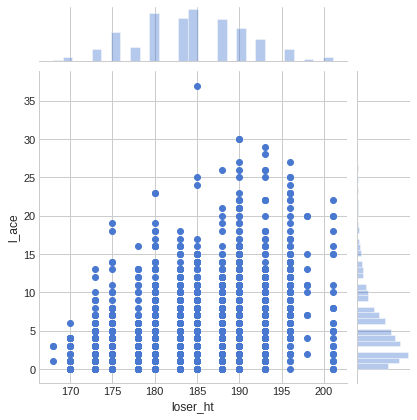

In [689]:
sns.jointplot(x="loser_ht", y="l_ace", data=df);

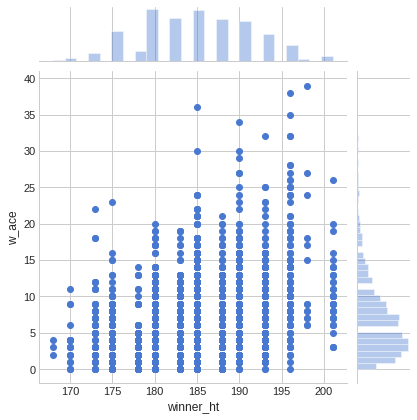

In [688]:
sns.jointplot(x="winner_ht", y="w_ace", data=df);

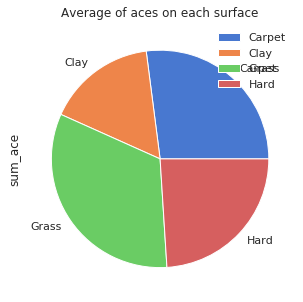

In [567]:
# sum w_ace and l_ace and create a column from it.
df['sum_ace'] = df['w_ace'] + df['l_ace']
w_ace_by_surface = df.groupby('surface', as_index = False)['sum_ace'].mean()
w_ace_by_surface['w_ace'] = w_ace_by_surface['sum_ace'].astype(int)
w_ace_by_surface.index = w_ace_by_surface['surface']
# pie plot of total of winner aces per surface
w_ace_by_surface = w_ace_by_surface.drop('surface', axis=1)
w_ace_by_surface.plot('surface','sum_ace', kind='pie', title='Average of aces on each surface',figsize=(5,5))


In [644]:
l_w_ranks = df[['loser_rank', 'loser_name']]

aa = l_w_ranks[l_w_ranks["loser_rank"] < 10]

aa.head()

,loser_rank,loser_name
47,1.0,Andre Agassi
77,4.0,Nicolas Kiefer
92,3.0,Yevgeny Kafelnikov
156,2.0,Gustavo Kuerten
157,1.0,Andre Agassi


In [639]:
# average minutes per surface
match_length_by_surf = df.groupby('surface', as_index = False)['minutes'].mean()
match_length_by_surf['minutes'] = match_length_by_surf['minutes'].astype(int)
match_length_by_surf.plot('surface', kind='bar', title='Average of minutes on each surface')


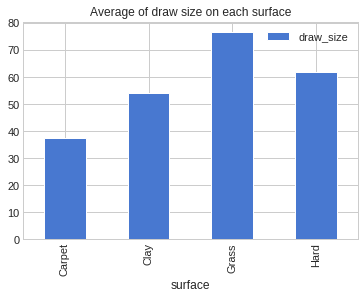

In [672]:
# average draw size per surface
draw_size_by_surface = df.groupby('surface', as_index = False)['draw_size'].mean()
draw_size_by_surface.plot('surface', kind='bar', title='Average of draw size on each surface')



In [664]:
# bin on winner_rank and take the mean of w_1stIn and  w_1stWon and stack them
df_w['rank_bin']=pd.cut(x=df['winner_rank'], bins=[1,10,50,100,200,500,1000], 
                        labels=["1-10", "10-50", "50-100","100-200","200-500","500-1000"])


plot_variables = df_w[['rank_bin','w_1stIn','w_1stWon']]
indexes = plot_variables.set_index('rank_bin')
rank_bin = indexes.groupby('rank_bin').mean()

rank_bin.plot.bar(stacked=True)


In [572]:
# pd.DataFrame(data=train_X,index=train_X.,columns=train_X.columns)


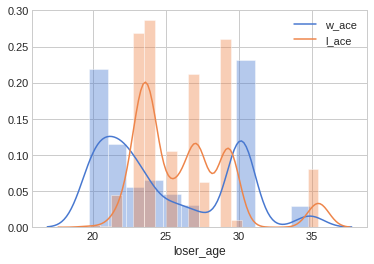

In [666]:
df = df.dropna()
sns.distplot(df.loc[df['w_ace']]['winner_age'], kde_kws={"label": "w_ace"});
sns.distplot(df.loc[df['l_ace']]['loser_age'], kde_kws={"label": "l_ace"});


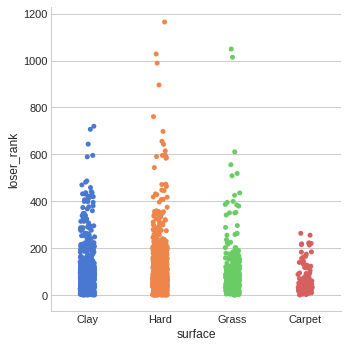

In [674]:
sns.catplot(x="surface", y="loser_rank",  data=df);


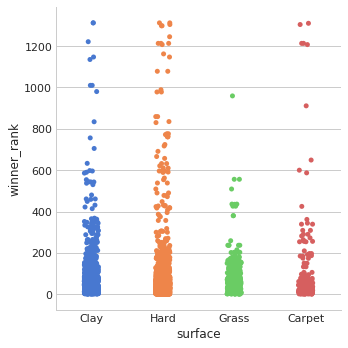

In [574]:
sns.catplot(x="surface", y="winner_rank",  data=df);


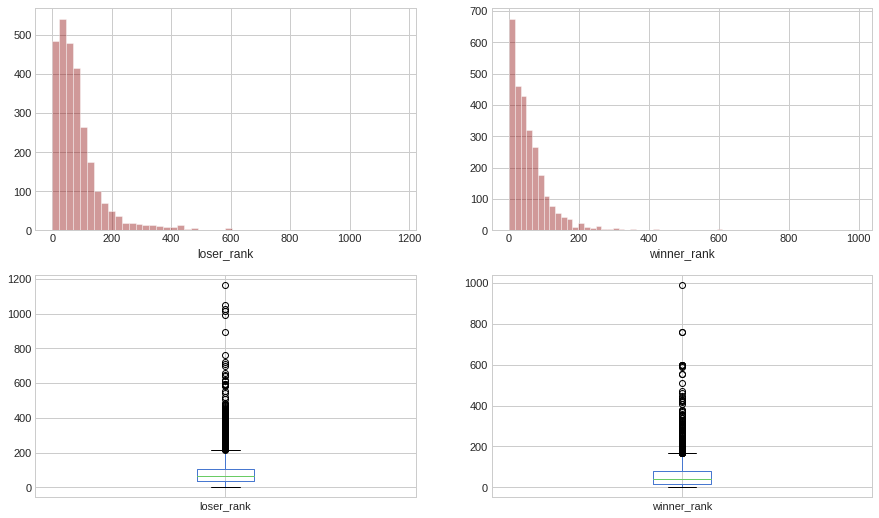

In [722]:
# frequency distribution
w_rank = pd.Series(df['winner_rank'])
l_rank = pd.Series(df['loser_rank'])
concate_ranks = pd.concat([w_rank, l_rank])

f, axes = plt.subplots(2, 2, figsize=(15, 9),)

sns.distplot(l_rank,kde=False,color='darkred',bins=50, ax=axes[0,0])
sns.distplot(w_rank,kde=False,color='darkred',bins=60, ax=axes[0,1])
df.boxplot(column='loser_rank',ax=axes[1,0])
df.boxplot(column='winner_rank',ax=axes[1,1])


In [580]:

# from sklearn.preprocessing import OneHotEncoder

# train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

# numerical_cols = [cname for cname in train_X.columns if 
#                 train_X[cname].dtype in ['int64', 'float64']]

# train_X = train_X[numerical_cols].copy()

# categorical_cols = [cname for cname in train_X.columns if
#                     train_X[cname].nunique() < 10 and 
#                     train_X[cname].dtype == "object"]


# # Keep selected columns only
# my_cols = categorical_cols + numerical_cols
# X_train = train_X[my_cols].copy()
# X_valid = train_X[my_cols].copy()
# X_test = train_X[my_cols].copy()

# numerical_transformer = SimpleImputer(strategy='constant')

# # Preprocessing for categorical data
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# # Bundle preprocessing for numerical and categorical data
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_cols),
#         ('cat', categorical_transformer, categorical_cols)
#     ])

# train_X = preprocessor.fit_transform(train_X, train_y)

#######################################################

# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2

# bestfeatures = SelectKBest(score_func=chi2, k=10)
# fit = bestfeatures.fit(np.nan_to_num(train_X), np.nan_to_num(train_y))
# dfscores = pd.DataFrame(fit.scores_)
# dfcolumns = pd.DataFrame(X.columns)
# #concat two dataframes for better visualization 
# featureScores = pd.concat([dfcolumns,dfscores],axis=1)
# featureScores.columns = ['Specs','Score']  #naming the dataframe columns
# featureScores.nlargest(10,'Score')  #print 10 best features

In [581]:
df.draw_size.unique()

array([ 32, 128,  48,  64,  96,  56,   8,   4])

In [582]:
df.tourney_level.unique()

array(['A', 'G', 'M', 'F', 'D'], dtype=object)

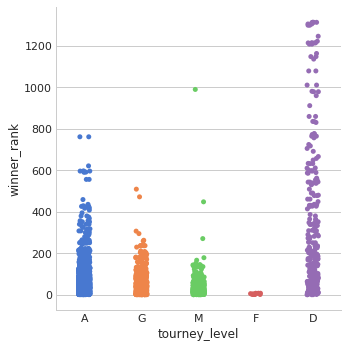

In [583]:
winner_rank_by_tourney = df.groupby('tourney_level', as_index = False)['winner_rank']
#winner_rank_by_tourney.plot('tourney_level', kind='bar', title='Rank average on each tourney level')
sns.catplot(x="tourney_level", y="winner_rank",  data=df);

In [584]:
# # remove outliers
# from scipy import stats
# z = np.abs(stats.zscore(df['w_ace']))
# threshold = 3
# print(np.where(z > 3))
# print(z[109])
# df_o = df[(z < 3)]

# #df_o.shape
# df_o.head()
# #sns.jointplot(x="winner_ht", y="winner_ht", data=df_o);





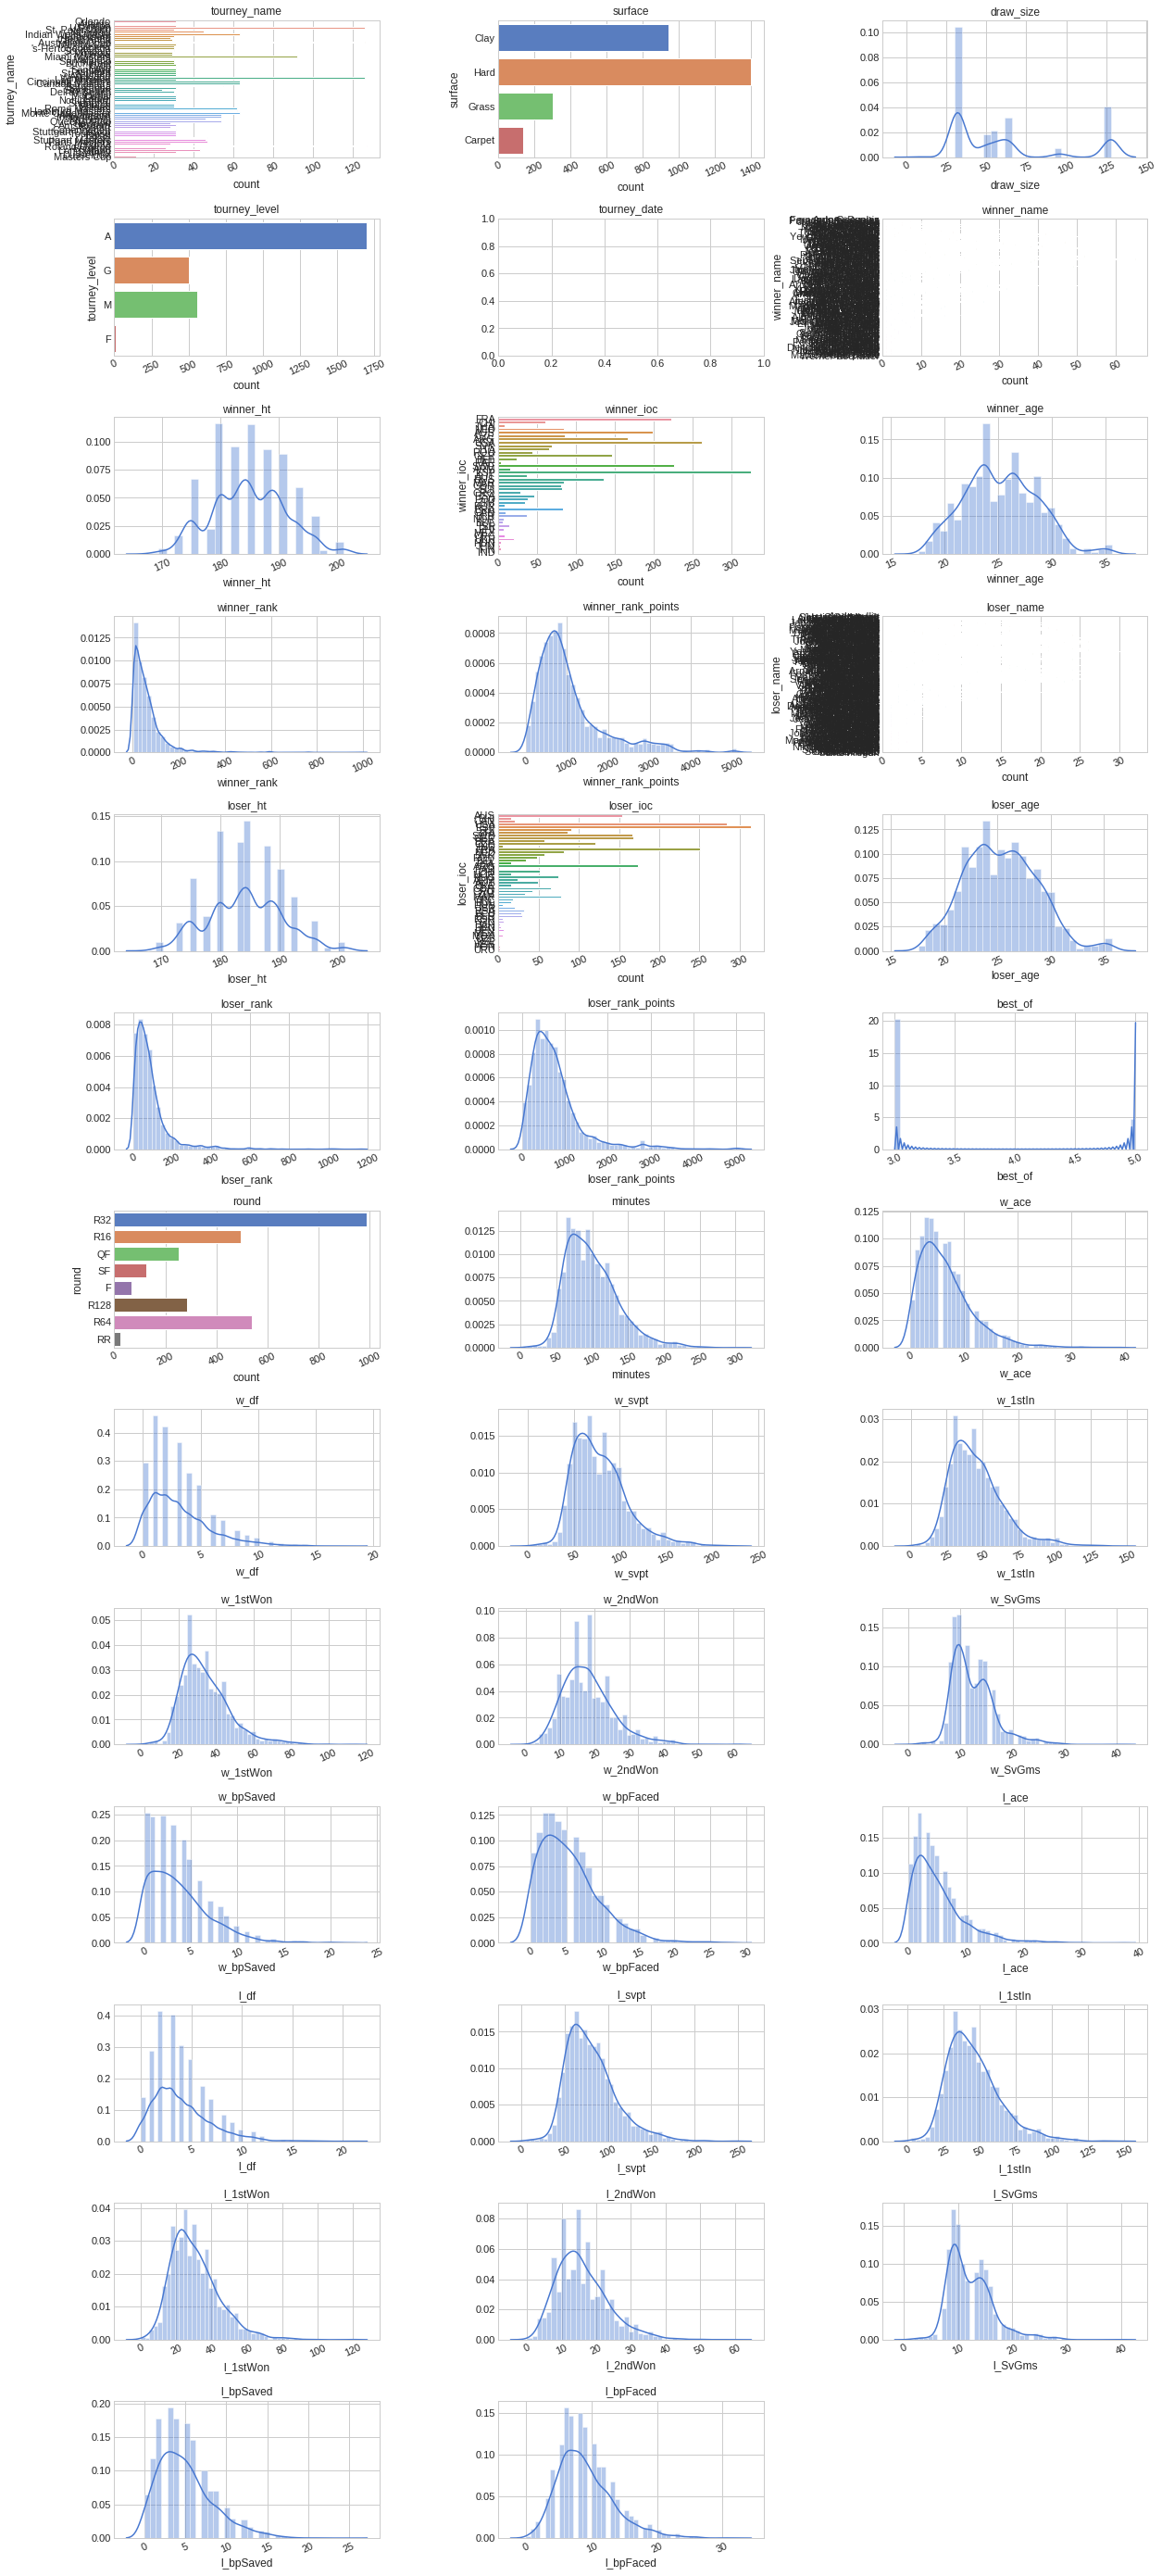

In [625]:
df_w =  df_w.dropna()


